In [1]:
# !pip install matplotlib
# !pip install torch 

In [212]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (5, 4)

## Create clusters

In [213]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

In [214]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [215]:
n_clusters=6
n_samples =250

In [216]:
def sample(cent, n=n_samples): return MultivariateNormal(cent, torch.diag(tensor([5.,5.]))).sample((n,))

In [217]:
sample(tensor([10.,10.]), 3)

tensor([[10.753, 10.288],
        [10.524, 10.515],
        [ 7.489,  9.583]])

In [218]:
centroids = torch.rand(n_clusters, 2)*70-35
centroids

tensor([[ 25.858,   4.740],
        [ 16.877,  -4.942],
        [ 26.981,   5.173],
        [-16.339,   8.921],
        [-16.126,  -4.105],
        [-14.216,  23.218]])

In [219]:
data = torch.cat([sample(c) for c in centroids])
data.shape

torch.Size([1500, 2])

In [220]:
def plot_data(centroids, data, n_samples=n_samples,  ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

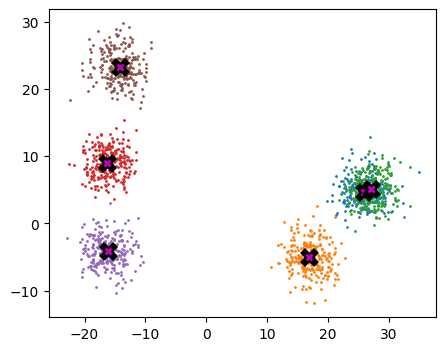

In [221]:
plot_data(centroids, data)

## Mean shift algo 

In [222]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [223]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

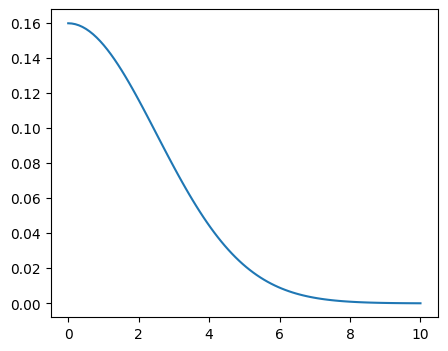

In [224]:
plot_func(partial(gaussian, bw=2.5))

In [225]:
X = data.clone()
x = X[0]
X.shape, x.shape

(torch.Size([1500, 2]), torch.Size([2]))

In [226]:
dists = ((X - x)**2).sum(axis=1).sqrt(); dists

tensor([ 0.000,  2.813,  3.713,  ..., 45.739, 45.099, 45.383])

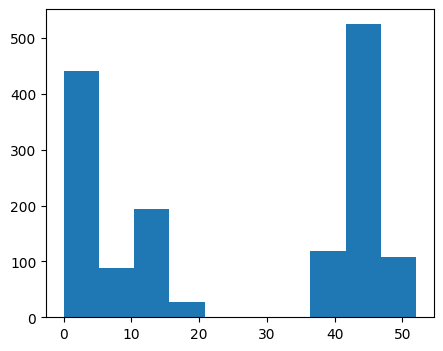

In [227]:
plt.hist(dists);

In [228]:
weights = gaussian(dists, bw=2.5); weights 

tensor([0.160, 0.085, 0.053,  ..., 0.000, 0.000, 0.000])

In [229]:
update = (weights[:, None]* X).sum(axis=0) / weights.sum(); update

tensor([26.504,  4.228])

In [230]:
x + update 

tensor([53.158,  7.433])

In [231]:
x

tensor([26.654,  3.205])

In [232]:
def one_update(X):
    for i, x in enumerate(X):
        dists = ((X - x)**2).sum(1).sqrt()
        weights = gaussian(dists, bw=2.5)
        update = (weights[:, None]* X).sum(0) / weights.sum()
        X[i] = update

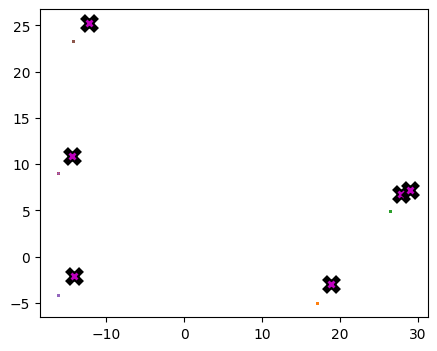

In [233]:
X = data.clone()
for i in range(10):
    one_update(X)
plot_data(centroids + 2, X)

In [234]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [235]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [236]:
# create your own animation
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=8, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

## Broadcasting 

Every point is updated relative to the distances to every other point. Each distance vector and update is calculated in a loop. Rather this could be done using broadcasting. 

We have 1500 points (x,y) and each one has a distance (or diff) with every other point, making a [1500, 1500, 2] tensor. 

In [237]:
data.shape

torch.Size([1500, 2])

In [238]:
bs=5
X = data.clone()
x = X[:bs]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

If we reshape each matrix to have a 1 in corresponding spots, by broadcasting we should get all combinations. 

In [239]:
X[None].shape, x[:,None].shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]))

Now we can get all diffs (diff of each of the 5 in the batch with each of the 1500 points)

In [240]:
(X[None] - x[:,None]).shape

torch.Size([5, 1500, 2])

In [241]:
dists = ((X[None] - x[:,None])**2).sum(2).sqrt()
weights = gaussian(dists, bw=2.5)
weights.shape

torch.Size([5, 1500])

In [242]:
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt()

In [243]:
X[None].shape

torch.Size([1, 1500, 2])

In [244]:
(X[None]*weights[...,None]).sum(1) 

tensor([[1066.529,  170.149],
        [1036.003,  200.820],
        [ 764.999,  147.249],
        [ 255.450,   47.266],
        [1062.767,  183.147]])

In [245]:
weights.sum(1)[:,None]

tensor([[40.241],
        [40.332],
        [30.516],
        [10.767],
        [41.119]])

In [246]:
(X[None]*weights[...,None]).sum(1) / weights.sum(1)[:,None]

tensor([[26.504,  4.228],
        [25.687,  4.979],
        [25.069,  4.825],
        [23.726,  4.390],
        [25.846,  4.454]])

^ these are the updated values for the 5 in the batch. It's the sum of the weighted 1500 points, where weights are the distances to the given point. The weights are normalized by the sum of weights over the 1500.  

In [249]:
weights@X / weights.sum(1)[:,None]

tensor([[26.504,  4.228],
        [25.687,  4.979],
        [25.069,  4.825],
        [23.726,  4.390],
        [25.846,  4.454]])

In [250]:
x

tensor([[26.654,  3.205],
        [24.755,  5.280],
        [23.374,  4.945],
        [20.678,  4.255],
        [25.166,  3.855]])

In [251]:
def meanshift(data, bs=500, steps=5):
    n = len(data)
    X = data.clone()
    for it in range(steps):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div
    return X

def meanshift_loop(data, steps=5):
    X = data.clone()
    for it in range(steps):
        one_update(X)
    return X

In [252]:
meanshift(data)

tensor([[ 26.469,   4.916],
        [ 26.469,   4.916],
        [ 26.469,   4.916],
        ...,
        [-14.264,  23.256],
        [-14.264,  23.256],
        [-14.264,  23.256]])

In [198]:
meanshift_loop(data)

tensor([[  0.036,   4.978],
        [  0.036,   4.978],
        [  0.036,   4.978],
        ...,
        [ 33.364, -13.051],
        [ 33.364, -13.051],
        [ 33.364, -13.051]], device='mps:0')

### Time it on the CPU 

In [253]:
data.device

device(type='cpu')

In [254]:
%timeit -n 10 _=meanshift(data, bs=1024).cpu()

36.1 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Time it on the GPU

In [257]:
import platform
print("Runnning on platform:", platform.system())
if platform.system() == 'Darwin':
    data = data.to("mps")
else:
    data = data.to("cuda")
data.device

Runnning on platform: Darwin


device(type='mps', index=0)

In [258]:
%timeit -n 10 _=meanshift(data, bs=1024).cpu()

9.5 ms ± 4.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Time it as a loop (no broadcasting)

In [259]:
%timeit -n 5 _=meanshift_loop(data).cpu()

2.98 s ± 45.4 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


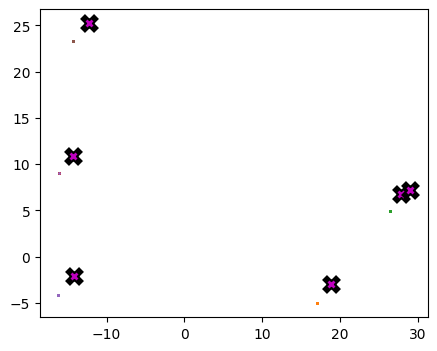

In [260]:
X = meanshift(data).cpu()
plot_data(centroids+2, X, n_samples)